<a href="https://colab.research.google.com/github/Tommy-Ngx/ColabRerun/blob/main/Segmentation/UNIMIB2016fast2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table align="left"><td>
  <a target="_blank"  href="https://colab.research.google.com/github/Tommy-Ngx/ColabRerun/blob/main/Segmentation/UNIMIB2016fast.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab
  </a>
</td><td>
  <a target="_blank"  href="https://github.com/Tommy-Ngx/ColabRerun/blob/main/Segmentation/trayfood.ipynb">
    <img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
</td></table>

![](https://cdn.theatlantic.com/thumbor/npZfAjSjxXVdQoYrvTSm6th1GHY=/584x0:2917x2333/500x500/media/img/mt/2016/01/RTX22DCB/original.jpg)

Welcome to this notebook where I try to segment pictures of various items on a food tray using UNets with an architecture of ResNet34. This is my first time doing segmentation in computer vision so do correct me and give any suggestions in the comments :)

An [article on Medium](https://towardsdatascience.com/fastai-image-segmentation-eacad8543f6f) about the same helped me quite a lot, so do check it out.

# Importing the Libraries:

In [ ]:
!git clone https://github.com/Tommy-Ngx/ColabRerun

Cloning into 'ColabRerun'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 47 (delta 16), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (47/47), done.


In [ ]:
!unzip /content/ColabRerun/TrayFood.zip

In [1]:
import os
os.environ['KAGGLE_USERNAME'] = " xx" # username from the json file
os.environ['KAGGLE_KEY'] = "xxx" # key from the json file

!kaggle datasets download -d tommyngx/unimib2016pre4

100% 2.17G/2.18G [00:16<00:00, 112MB/s]
100% 2.18G/2.18G [00:16<00:00, 141MB/s]


In [ ]:
!pip install "torch==1.4" "torchvision==0.5.0"

In [ ]:
!pip install keras==2.4.3
!pip install tensorflow==2.3.1

In [4]:
!pip install --no-deps fastai==1.0.61

In [ ]:
!unzip /content/unimib2016pre4.zip

In [3]:
!rm -rf /content/test/annotation.json
!rm -rf /content/val/annotation.json
!rm -rf /content/train/annotation.json

In [ ]:
from PIL import Image
import os, sys
import glob
import cv2
from google.colab.patches import cv2_imshow
root_dir = "/content/val/"
for filename in glob.iglob(root_dir + '**/*.jpg', recursive=True):
    print(filename)
    im = Image.open(filename)
    imResize = im.resize((500,375), Image.ANTIALIAS)
    imResize.save(filename , 'JPEG', quality=90)
root_dir = "/content/valmask/"
for filename in glob.iglob(root_dir + '**/*.png', recursive=True):
    print(filename)
    im = Image.open(filename)
    imResize = im.resize((500,375), Image.ANTIALIAS)
    imResize.save(filename , 'PNG', quality=90)
root_dir = "/content/valmask2/"
for filename in glob.iglob(root_dir + '**/*.png', recursive=True):
    print(filename)
    im = Image.open(filename)
    imResize = im.resize((500,375), Image.ANTIALIAS)
    imResize.save(filename , 'PNG', quality=90)

In [ ]:
k = cv2.imread("/content/valmask2/20151127_115951.png")
k.shape
cv2_imshow(k)#[:,:,2])
#print(k#[:,:,])

In [7]:
valmask=[]; val=[]
for filename2 in glob.iglob('/content/valmask2/**/*.png', recursive=True):
    filex2 = filename2.split("/")[-1][:-4]
    valmask.append(filex2)
for filename in glob.iglob('/content/val/**/*.jpg', recursive=True):
  filex = filename.split("/")[-1][:-4]
  val.append(filex)
  if filex not in valmask:
    print(filex)
print(len(valmask),"+++",len(val))

192 +++ 192


In [1]:
#Importing the FastAI libraries:

import numpy as np
import pandas as pd
from fastai.vision import *
from fastai.metrics import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

# Data Prep:

Down here I am preparing the data to be trained and fastAI's library is quite simplistic to use like, anyone can train a UNet using it and do segmentation.

In [12]:
# Defining the path where my JPG images are stored:
trainpath = "/content/val/"
#trainpath = "/content/TrayDataset/TrayDataset/XTrain/"
# Defining the path where the mask PNG images of the images mentioned above are stored:
trainlabel = "/content/valmask2/"
#trainlabel = "/content/TrayDataset/TrayDataset/yTrain/"

# Taking out the JPG filenames out of the training data folder:
fnames = get_image_files(trainpath)

Below is a function which defines how our data module will find the labels to the images it learns segmentation with. Lambda in layman's language here refers to defining a function with input x.

*trainlabel* refers to the folder path where all the labels are stored.

*x.stem* refers to the image's name while, .PNG is concatenated with it because the mask is not a JPG but a PNG. 

In [13]:
get_y = lambda x: trainlabel + x.stem + '.png' 

Lets take a look at the images and their respective masks:

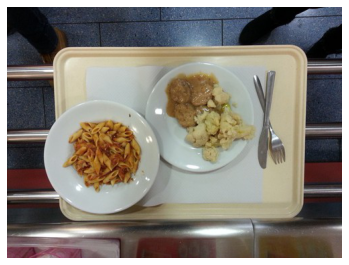

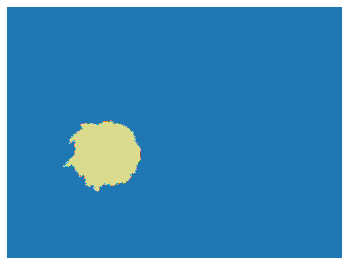

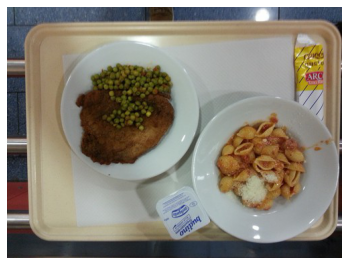

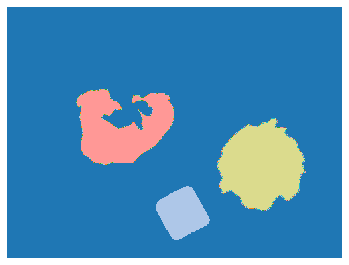

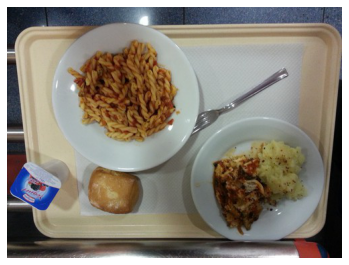

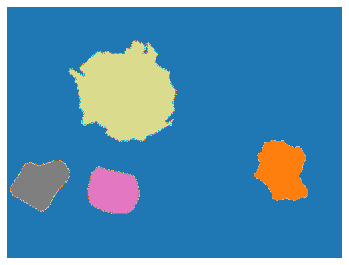

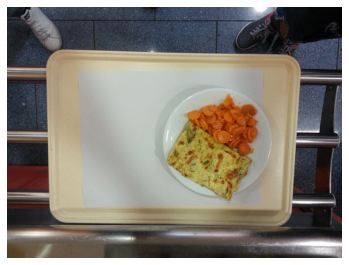

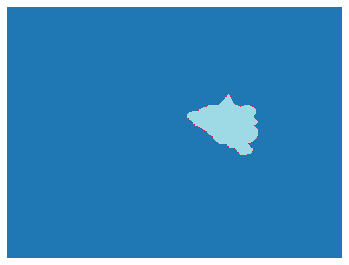

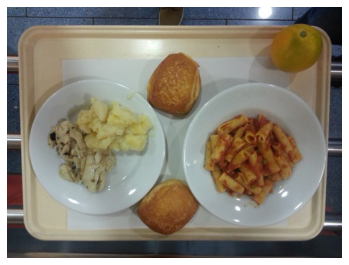

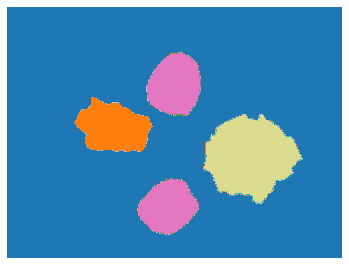

In [14]:
for i in range(10,15):
    img = open_image(fnames[i])
    mask = open_mask(get_y(fnames[i]))
    img.show(figsize=(6,6)), mask.show(figsize=(6,6), alpha=1)

Noting important measures:

The classes are stored in a csv so taking a look at it:

In [ ]:
classescsv = pd.read_csv("/content/classes.csv")
classescsv.head()
classes = list(classescsv['_class'])
classes

I will now seperate out the _class since it contains the classes and turn it into a list:

In [15]:
#classes = ['BG', 'pudding/custard', 'smashed potatoes',  'carrots', 'spanich','veal breaded cutlet',
#           'oranges','scallops', 'beans', 'bread', 'yogurt','pizza','pasta']
classes = ['BG', 'pudding/custard', 'smashed potatoes',  'carrots', 'spanich','veal breaded cutlet',
           'oranges','scallops', 'beans', 'bread', 'yogurt','pizza']
#classes = [['background','tray']]                     
print(len(classes))

12


In [18]:
src_shape = np.array(mask.shape[1:])
size = src_shape // 1
bs = 12

#Finally defining the data our model will run on:
src = (SegmentationItemList
       .from_folder(trainpath)
       .split_by_rand_pct(.2)
       .label_from_func(get_y, classes=classes))

data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [21]:
data.show_batch(1, figsize=(6,6))

RuntimeError: ignored

# Training and Predicting:

In [8]:
#Defining and downloading the UNet:
learner = unet_learner(data, models.resnet34)
#Training the data:
learner.fit_one_cycle(3)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,time


RuntimeError: ignored

Since the both the losses seem small enough, lets predict:

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


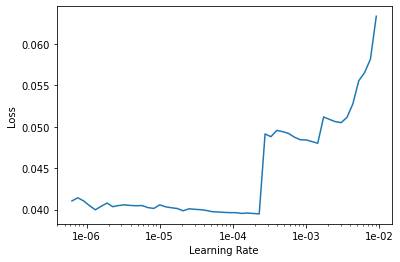

In [ ]:
learner.save('/content/trayseg.pth') # save model

learner.lr_find() # find learning rate
learner.recorder.plot() # plot learning rate graph

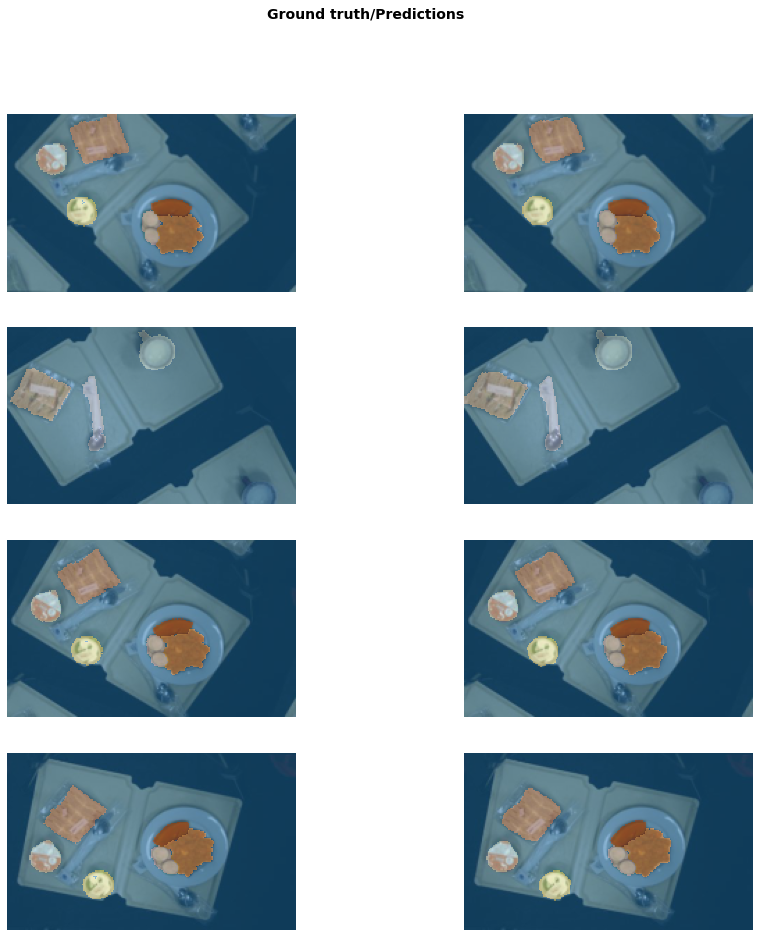

In [ ]:
learner.show_results(figsize=(15,15))

On the left is the actual images while on the left is the predictions! They look almost identical and thereby here I conclude this notebook.

If you liked this notebook, an upvote would be of tremendous help as I trot forward with my infatuation with Deep Learning :)

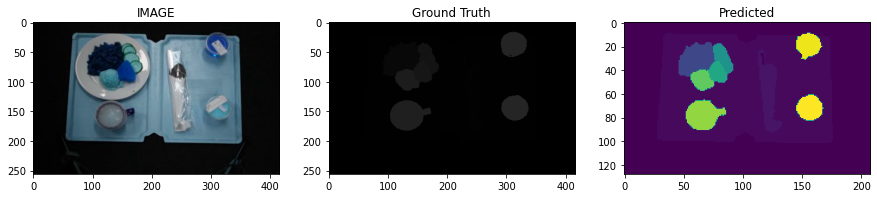

In [ ]:
img = open_image('/content/TrayDataset/TrayDataset/XTest/2002a.jpg')
img2 = cv2.imread("/content/TrayDataset/TrayDataset/XTest/2002a.jpg")
prediction = learner.predict(img)
prediction[0].save('temp1.png')
#prediction2  = open_mask("temp1.png")
ground_truth_mask = cv2.imread("/content/TrayDataset/TrayDataset/yTest/2002a.png",cv2.COLOR_RGB2BGR)
ground_truth_mask = cv2.cvtColor(ground_truth_mask, cv2.COLOR_BGR2RGB)
prediction2       = cv2.imread("temp1.png",cv2.COLOR_RGB2BGR)


fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(1,3,1)
ax1.set_title("IMAGE")
ax1.imshow(img2)
ax2 = fig.add_subplot(1,3,2)
ax2.set_title("Ground Truth")
ax2.imshow(ground_truth_mask)
ax3 = fig.add_subplot(1,3,3)
ax3.set_title("Predicted")
ax3.imshow(prediction2)

In [ ]:
print(ground_truth_mask.shape)

(256, 416, 3)


In [ ]:
best_model = torch.load('/content/trayseg.pth.pth')
